In [1]:
# Simulated BB clustering notebook using simple Acid set from Enamine.
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
import numpy as np
#from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import kmedoids

import seaborn as sns
import umap

from tqdm import tqdm

from rdkit import Chem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_fingerprint(mol,radius,bits):
    try:
        fp=AllChem.GetMorganFingerprintAsBitVect(mol,radius,bits)
        return(fp)
    except:
        print(f'{mol} failed in RDkit')
        return (np.nan)

In [3]:
df = PandasTools.LoadSDF(filename = "Data/Enamine_Rush-Delivery_Building_Blocks-US_264766cmpd_20250604.sdf")
print(len(df))
# add a few descriptors:
df['rot_b'] = df['ROMol'].apply(lambda x: Chem.rdMolDescriptors.CalcNumRotatableBonds(x))
df['HAC'] = df['ROMol'].apply(lambda x:  Chem.rdMolDescriptors.CalcNumHeavyAtoms(x))
df['MW'] = df['ROMol'].apply(lambda x:  Chem.rdMolDescriptors.CalcExactMolWt(x))
df['acid_count'] = df['ROMol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmarts('[CX3](=O)[OX1H0-,OX2H1]'))))



264765


In [4]:
df.head(2)

,Catalog_ID,IUPAC Name,CAS,purity,MDLNUMBER,LogP,URL,avail_US_100mg,avail_US_250mg,avail_US_1g,...,MP,avail_US_5g,avail_US_10g,avail_US_25g,avail_US_50g,avail_US_100g,rot_b,HAC,MW,acid_count
0,EN300-07843,"2-(2-ethoxy-4-formylphenoxy)-N,N-dimethylpropa...",733030-83-6,95.00,MFCD04635872,1.479,https://www.enaminestore.com/catalog/EN300-07843,X,X,X,...,NaN,NaN,NaN,NaN,NaN,NaN,6,19,265.131408,0
1,EN300-04783,"4-[2-(3,4-dichlorophenyl)-2-oxoethoxy]-3-metho...",723333-45-7,95.00,MFCD03960564,3.816,https://www.enaminestore.com/catalog/EN300-04783,X,X,X,...,137-138,NaN,NaN,NaN,NaN,NaN,6,22,338.011264,0


In [5]:
# filter out high # of rotatable bonds
# remove compounds with two acids
# remove ones with a primary or secondary amine
cur_size = len(df)

# only BBs with single acid:
df = df[df['acid_count']==1]
print(f"removed {cur_size - len(df)} non-single acids")
cur_size = len(df)
# remove those with a primary or secondary amine:
amine = Chem.MolFromSmarts('[NX3;H2,H1;!$(N-C=[O,N,S])]')
df = df[~(df['ROMol'] >= amine)]
print(f"removed {cur_size - len(df)} amines")
cur_size = len(df)

# remove high MW
df = df[df['MW']<200]
print(f"removed {cur_size - len(df)} MW > 250")
cur_size = len(df)
print(len(df))

# remove lots of rotatable bonds
df = df[df['rot_b']<4]
print(f"removed {cur_size - len(df)} with > 6 rot_bonds")
cur_size = len(df)
print(len(df))
df.reset_index(inplace=True,drop=True)

removed 210336 non-single acids
removed 9391 amines
removed 29816 MW > 250
15222
removed 1639 with > 6 rot_bonds
13583


In [6]:
# generate FPs
n=3
bits = 1024
df['fp'] = df['ROMol'].apply(lambda x: generate_fingerprint(x,n,bits))

In [7]:
# Calculate the Tanimoto distance matrix
distance_matrix = []
fp_list = df['fp'].to_list()
for i in tqdm(range(len(fp_list))):
    row = []
    for j in range(len(fp_list)):
        # Calculate Tanimoto similarity
        similarity = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
        
        # Convert to Tanimoto distance
        distance = 1 - similarity
        row.append(distance)
    distance_matrix.append(row)

distance_matrix = np.array(distance_matrix)
X = np.stack(df.fp)

100%|█████████████████████████████████████| 13583/13583 [15:44<00:00, 14.39it/s]


In [15]:
results = []
for i in tqdm(range(50,2000,50)):
    km = kmedoids.fasterpam(distance_matrix,i,random_state=42)
    labels = km.labels
    s_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    km_sil = kmedoids.silhouette(distance_matrix, labels)[0]
    results.append({'k_value':i, 'sil_score':s_score,'km_sil': km_sil, 'db_score': db_score})

100%|███████████████████████████████████████████| 39/39 [09:30<00:00, 14.64s/it]


<Axes: xlabel='k_value', ylabel='sil_score'>

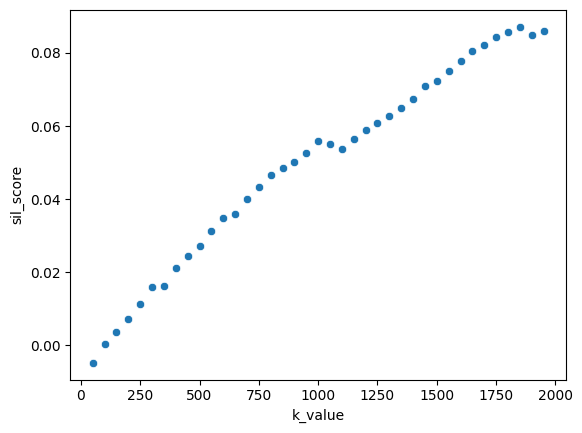

In [18]:
result_df = pd.DataFrame(results)
sns.scatterplot(data=result_df, x='k_value', y='sil_score')
#sns.scatterplot(data=result_df, x='k_value', y ='km_sil')

<Axes: xlabel='k_value', ylabel='db_score'>

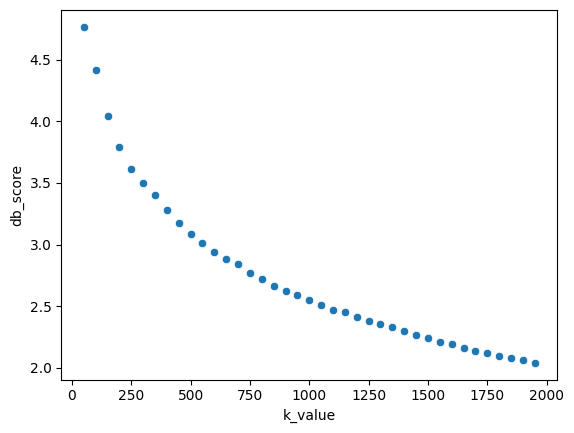

In [19]:
result_df = pd.DataFrame(results)
sns.scatterplot(data=result_df, x='k_value', y='db_score')

In [20]:
# Pick a reasonable number of clusters based on the scores & how many building blocks we would like
n= 900

In [21]:
km = kmedoids.fasterpam(distance_matrix,n)

In [22]:
df['cluster'] = km.labels
df['mediod'] = [1 if i in km.medoids else 0 for i in range(len(df)) ]

/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

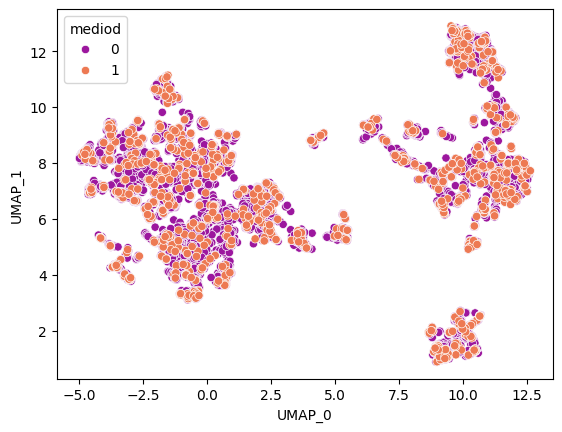

In [23]:
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = True,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(df['fp'].to_list())
df["UMAP_0"], df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

sns.scatterplot(data=df.sort_values(by='mediod'),x='UMAP_0',y='UMAP_1',hue='mediod', palette='plasma')

<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

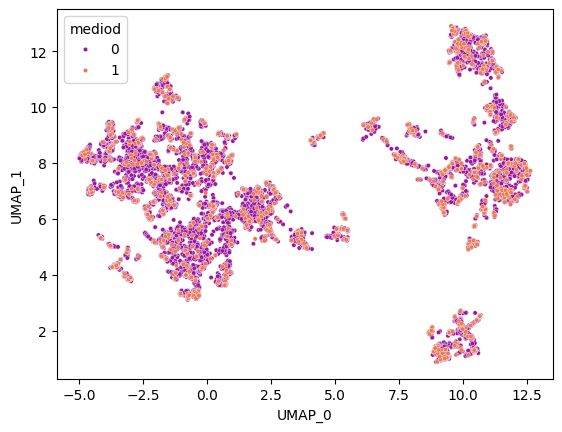

In [25]:
sns.scatterplot(data=df.sort_values(by='mediod'),x='UMAP_0',y='UMAP_1',hue='mediod', palette='plasma',s=10)

In [26]:
group_sizes = df.groupby('cluster').size()
top_medoid_clusters = group_sizes.sort_values(ascending=False)[0:200].index.to_list()

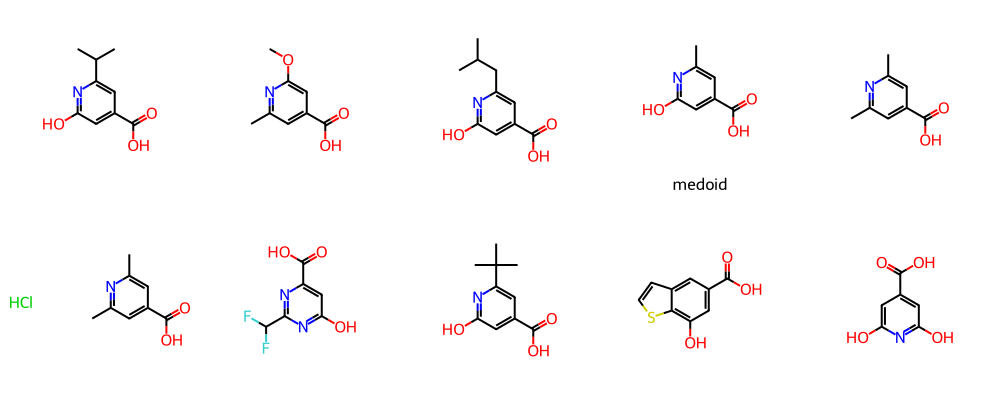

In [29]:
cluster= 2
Chem.Draw.MolsToGridImage(mols=df[df['cluster']==cluster]['ROMol'].to_list(),
                         legends=["medoid" if i==1 else "" for i in df[df['cluster']==cluster]['mediod']],
                         molsPerRow=5, subImgSize=(200, 200))

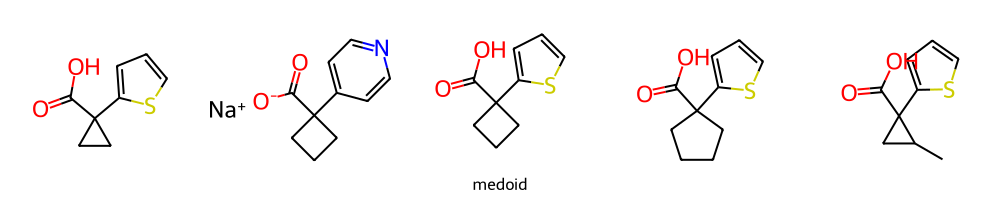

In [30]:
# 15, 18, 25, 35, 60, 71 
cluster= 71
Chem.Draw.MolsToGridImage(mols=df[df['cluster']==cluster]['ROMol'].to_list(),
                         legends=["medoid" if i==1 else "" for i in df[df['cluster']==cluster]['mediod']],
                         molsPerRow=5, subImgSize=(200, 200))

In [31]:
nfps = len(distance_matrix)
cutoff = 0.4
butina_cl = Butina.ClusterData(distance_matrix,nfps,cutoff,isDistData=True)
print(len(butina_cl))
cluster_id_list = [0]*nfps
for id,cluster in enumerate(butina_cl,1):
    for member in cluster:
        cluster_id_list[member] = id
cluster_id_list

10779


[10779,
 10778,
 166,
 557,
 523,
 10777,
 10776,
 10775,
 10774,
 10773,
 10772,
 818,
 1471,
 10771,
 10770,
 10769,
 10768,
 10767,
 1356,
 10766,
 991,
 1187,
 10765,
 10764,
 10763,
 10762,
 1649,
 10761,
 10760,
 779,
 328,
 10759,
 660,
 660,
 10758,
 10757,
 10756,
 10755,
 10754,
 10753,
 1729,
 10752,
 48,
 10751,
 10750,
 10749,
 1468,
 10748,
 10747,
 10746,
 10745,
 10744,
 10743,
 10742,
 10741,
 423,
 10740,
 10739,
 10738,
 10737,
 10736,
 809,
 10735,
 10734,
 801,
 10733,
 10732,
 10731,
 61,
 10730,
 10729,
 1592,
 10728,
 10727,
 10726,
 10725,
 10724,
 10723,
 10722,
 812,
 10721,
 10720,
 557,
 10719,
 10718,
 10717,
 10716,
 244,
 10715,
 1733,
 1414,
 10714,
 10713,
 1732,
 10712,
 1712,
 1545,
 10711,
 10710,
 10709,
 10708,
 10707,
 10706,
 1498,
 10705,
 10704,
 93,
 10703,
 10702,
 1306,
 10701,
 10700,
 10699,
 10698,
 10697,
 175,
 10696,
 475,
 48,
 10695,
 1708,
 10694,
 10693,
 10692,
 10691,
 10690,
 10689,
 10688,
 10687,
 10686,
 10685,
 1736,
 10684

In [32]:
df['butina_cluster']= cluster_id_list

<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

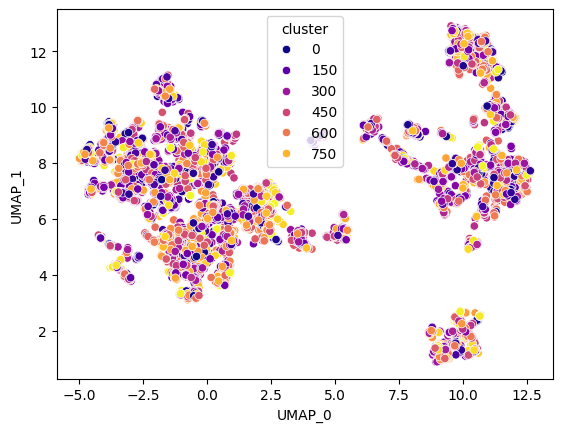

In [33]:
sns.scatterplot(data=df.sort_values(by='mediod'),x='UMAP_0',y='UMAP_1',hue='cluster', palette='plasma')

<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

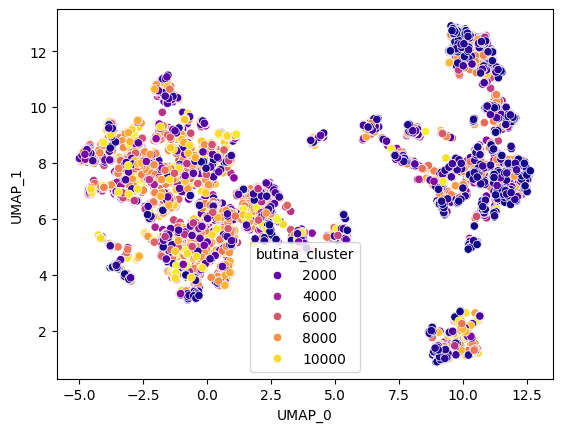

In [34]:
sns.scatterplot(data=df.sort_values(by='mediod'),x='UMAP_0',y='UMAP_1',hue='butina_cluster', palette='plasma')

In [35]:
butina_labels = df['butina_cluster'].to_list()
medoid_labels = df['cluster'].to_list()
butina_scores = (silhouette_score(X, butina_labels),davies_bouldin_score(X, butina_labels))
medoid_scores = (silhouette_score(X, medoid_labels),davies_bouldin_score(X, medoid_labels))
print(f"butina_scores:{butina_scores}")
print(f"medoid_scores:{medoid_scores}")

butina_scores:(np.float64(0.12315890649814251), np.float64(0.5327035087345255))
medoid_scores:(np.float64(0.04994312113025938), np.float64(2.635178506973683))


In [36]:
top_butina_medoids = [i[0] for i in butina_cl[0:50]]

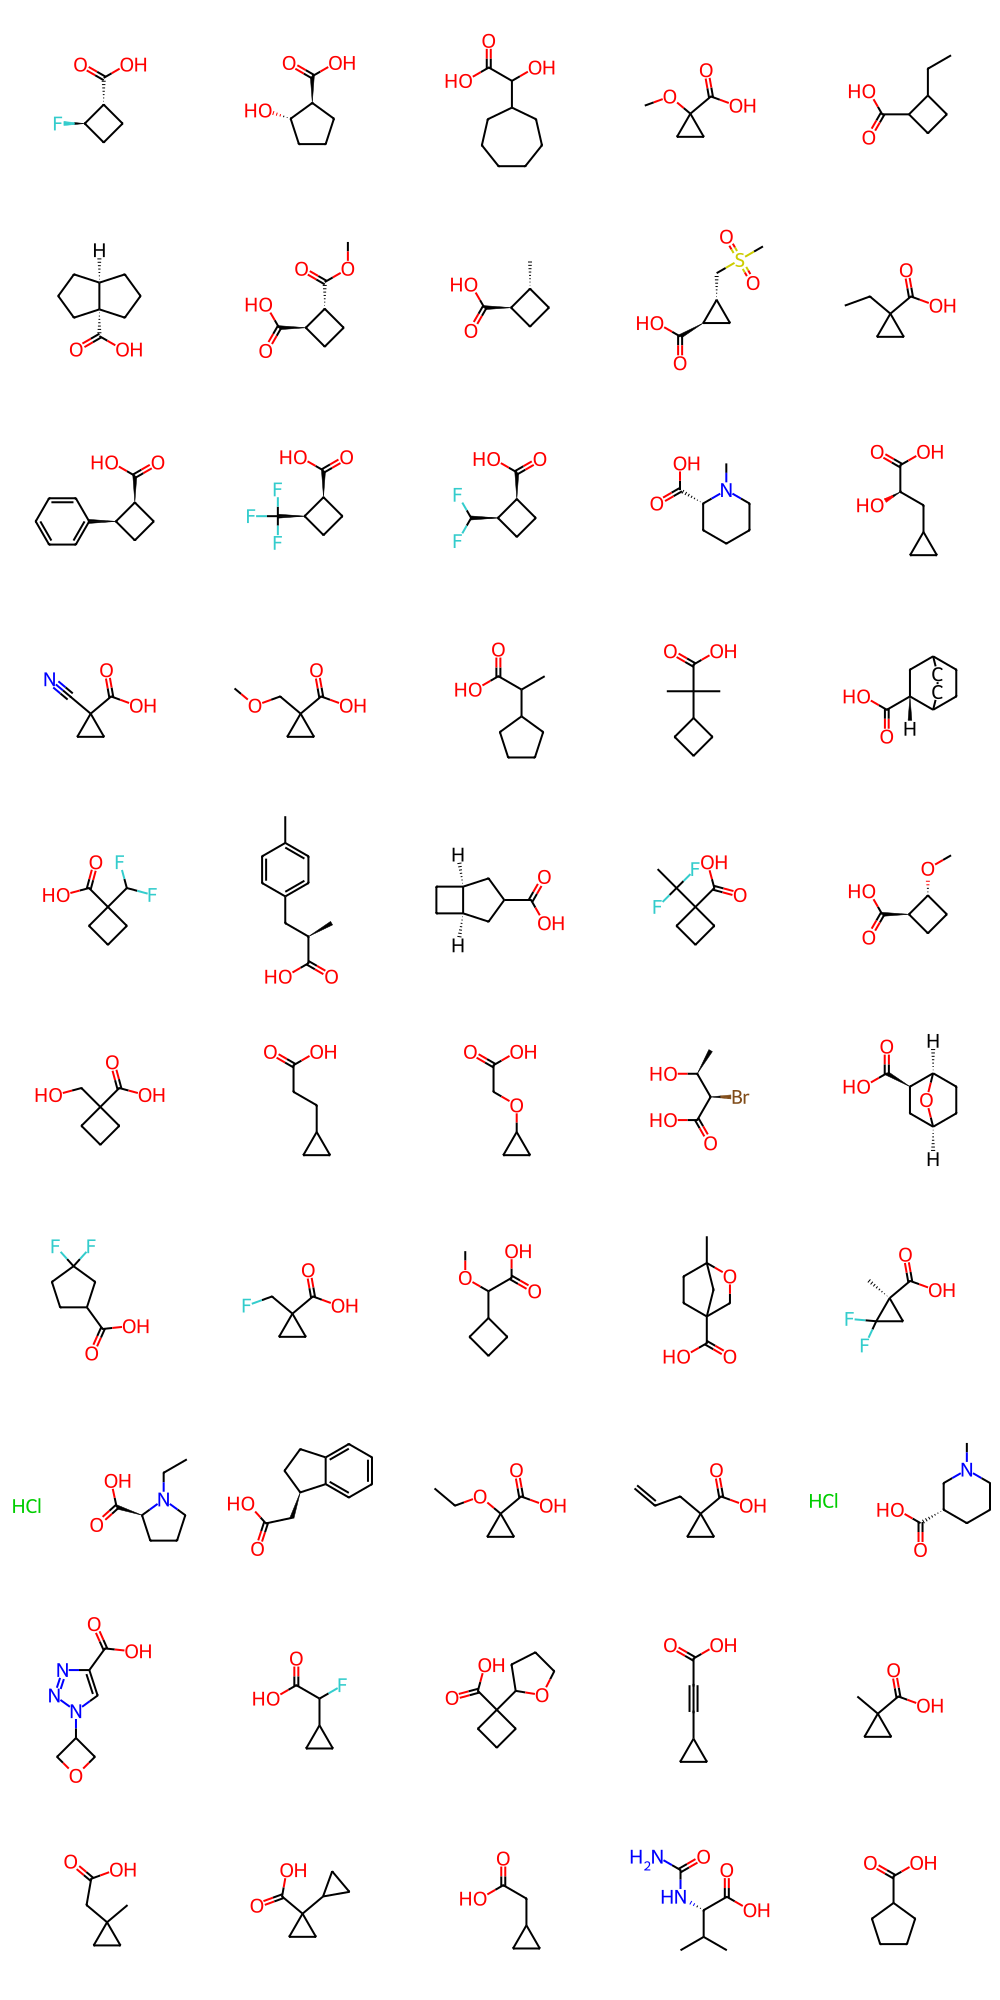

In [37]:
Chem.Draw.MolsToGridImage(df.loc[top_butina_medoids].ROMol.to_list(),molsPerRow=5)
# while Butina scores higher - some of these clusters have some significant overlap.

/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


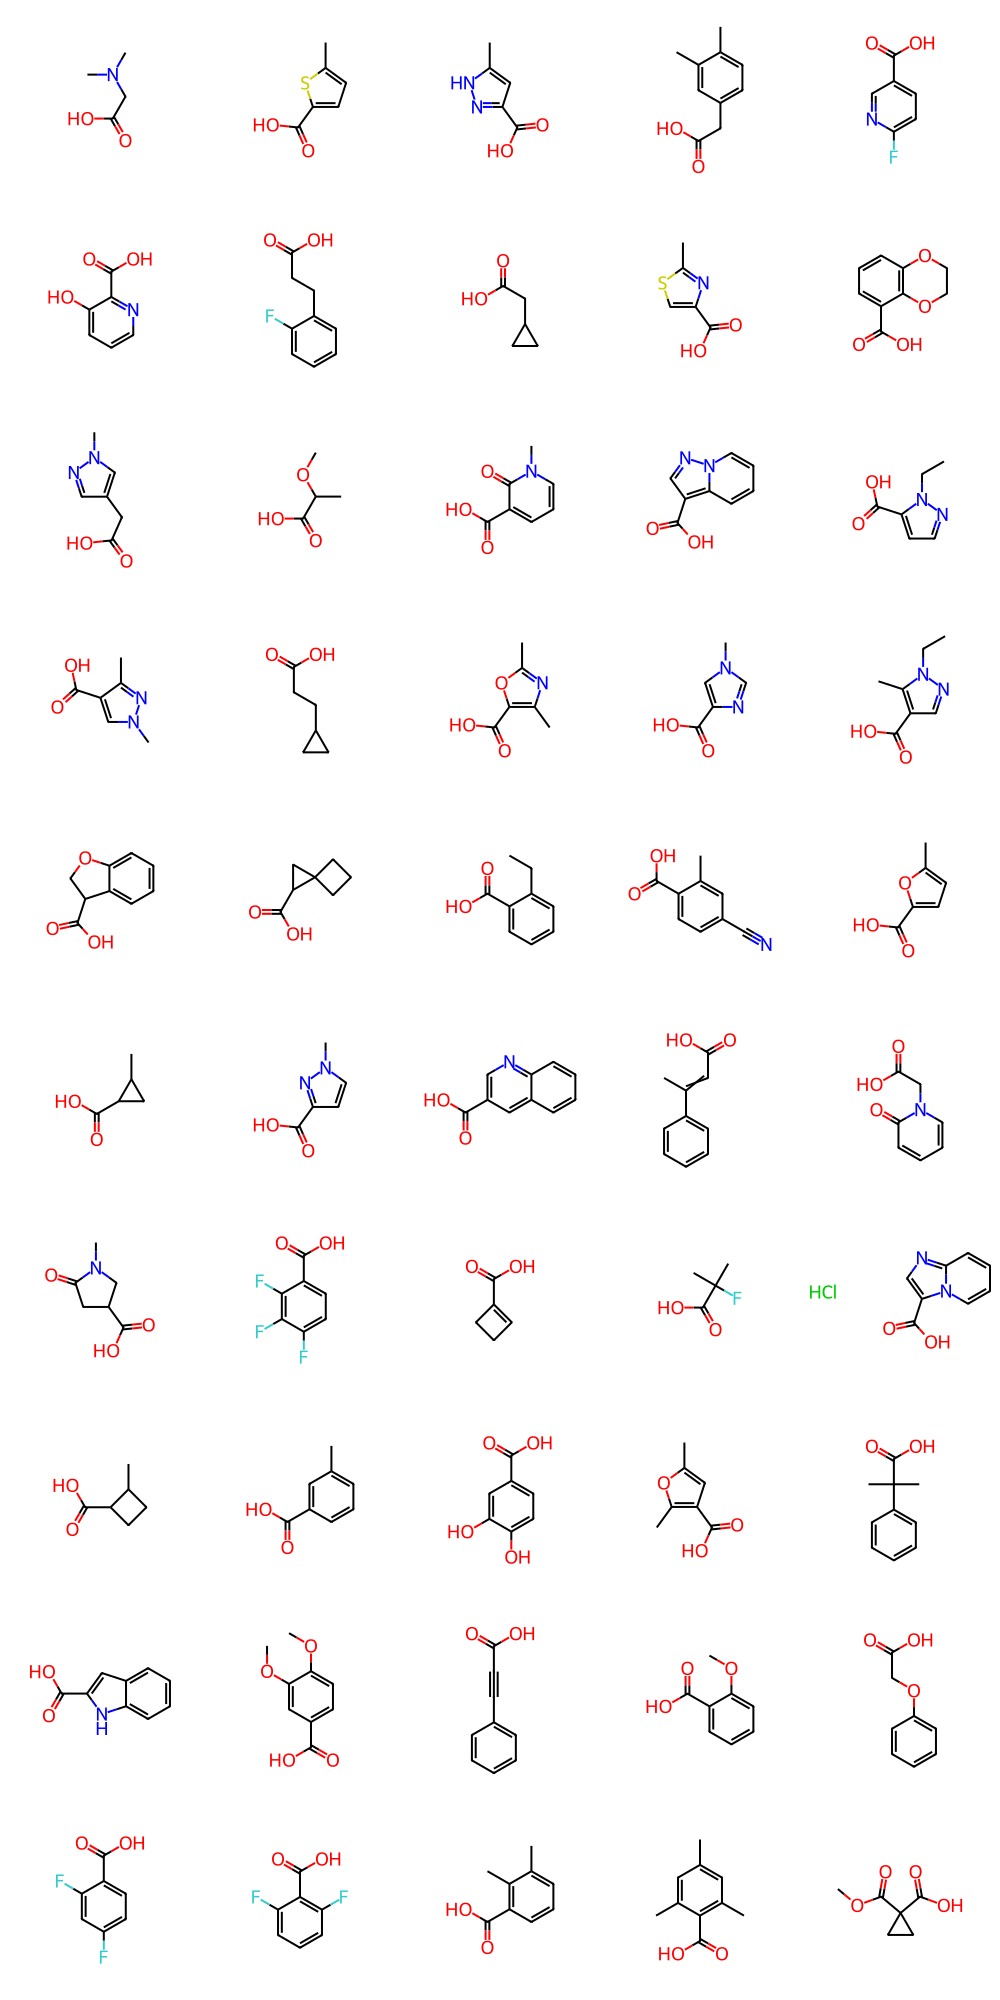

In [38]:
top_mediods = df[(df['cluster'].isin(top_medoid_clusters))&(df['mediod']==True)]
Chem.Draw.MolsToGridImage(top_mediods['ROMol'].to_list(),molsPerRow=5)